# Library Imports

# Dataset loading
dataset Courtesy: Mehran Soltani,et.al.

In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import time
import cv2

2024-11-04 12:47:31.209670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 12:47:31.209780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 12:47:31.336487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
srcdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/My_noisy_H_22.mat')
rcvdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/Perfect_H_40000.mat')
srcdata_ofdm= abs(srcdata['My_noisy_H']).reshape(-1,72,14,1)
rcvdata_ofdm= abs(rcvdata['My_perfect_H']).reshape(-1,72,14,1)
# trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [3]:
for i in range(len(srcdata_ofdm)):
    srcdata_ofdm[i]= srcdata_ofdm[i]/np.max(srcdata_ofdm[i])

for i in range(len(rcvdata_ofdm)):
    rcvdata_ofdm[i]= rcvdata_ofdm[i]/np.max(rcvdata_ofdm[i])

In [4]:
np.shape(srcdata['My_noisy_H'])

(40000, 72, 14)

In [5]:
np.max(rcvdata_ofdm[1])

1.0

# Data Exploration and LS Benchmark

In [6]:
# a=rcvdata['My_perfect_H'] #tx
# b=srcdata['My_noisy_H']  #rx
# # pilotstx=a[:,4:65:4,2:13:2]
# # pilotsrx=b[:,4:65:4,2:13:2]
# pilotstx=a
# pilotsrx=b
# plt.subplot(1,2,1)
# plt.imshow(abs(pilotstx[0]))
# plt.title('TX')
# plt.subplot(1,2,2)
# plt.imshow(abs(pilotsrx[0]))
# plt.title('RX')
# print(np.shape(pilotstx))

In [7]:
trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [8]:
model=keras.models.load_model('/kaggle/input/sigmodel/Sig2Sig.h5')

In [9]:
trainset=(trainData, trainLabels)
trainset=np.transpose(trainset,[1,0,2,3,4])
testset=(testData, testLabels)
testset=np.transpose(testset,[1,0,2,3,4])

In [10]:
np.shape(testset)

(8000, 2, 72, 14, 1)

In [28]:
def generate_images(model, test_input, tar):
    prediction = model(test_input.reshape(1,72,14,1), training=True)
    prediction=np.array(prediction[0]).astype('float64')
    prediction=prediction/np.max(prediction)
    print('The PSNR of faded image',cv2.PSNR(test_input, tar,1.0))
    print('The PSNR of equalised image',cv2.PSNR(prediction, tar,1.0))
    plt.figure(figsize=(15, 15))

    # display_list = [test_input[:,:,0],test_input[:,:,1], tar[:,:,0], prediction[0][:,:,0],tar[:,:,1],prediction[0][:,:,1]]
    # title = ['Input Image Real','Input Image CMPLX', 'Ground Truth Real', 'Predicted Image Real', 'Ground Truth CMPLX','Predicted Image CMPLX']

    # for i in range(6):
    #     plt.subplot(3, 2, i+1)
    #     plt.title(title[i])
    #     # Getting the pixel values in the [0, 1] range to plot.
    #     plt.imshow(display_list[i] * 0.5 + 0.5)
    #     plt.axis('off')
    # plt.show()

    display_list = [test_input[:,:,0],tar[:,:,0], prediction]
    title = ['Input Image','Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

<class 'numpy.ndarray'>
The PSNR of faded image 24.01007623421172
The PSNR of equalised image 23.06793584928532


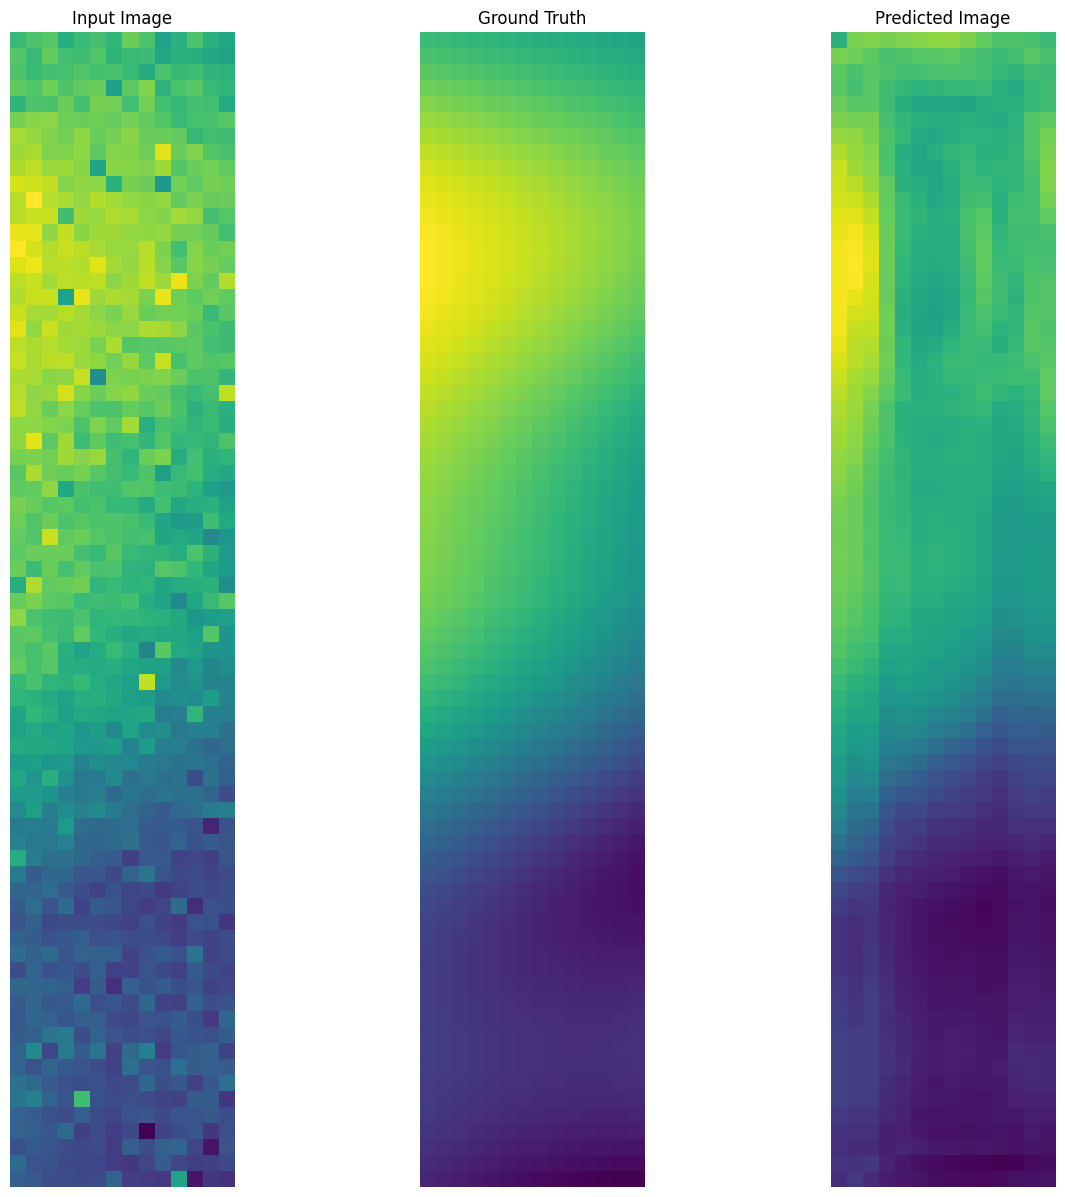

In [35]:
n=np.random.randint(len(testset))
test_input, tar=testset[n]
print(type(tar))
generate_images(model,test_input,tar)

In [69]:
from sklearn.metrics import mean_squared_error
psnrs=[]
mses=[]
metr={}
for i in range(len(testset)):
    print(i,end='\r')
    test_input,tar=testset[i]
    prediction = model(test_input.reshape(1,72,14,1), training=True)
    prediction=np.array(prediction[0]).astype('float64')
    prediction=prediction/np.max(prediction)
    # print('The PSNR of faded image',cv2.PSNR(test_input, tar,1.0))
    metr[cv2.PSNR(prediction, tar,1.0)]=mean_squared_error(prediction[:,:,0],tar[:,:,0])

In [77]:
metrf={}
for i in range(len(testset)):
    print(i,end='\r')
    test_input,tar=testset[i]
    # print('The PSNR of faded image',cv2.PSNR(test_input, tar,1.0))
    metrf[cv2.PSNR(test_input, tar,1.0)]=mean_squared_error(test_input[:,:,0],tar[:,:,0])

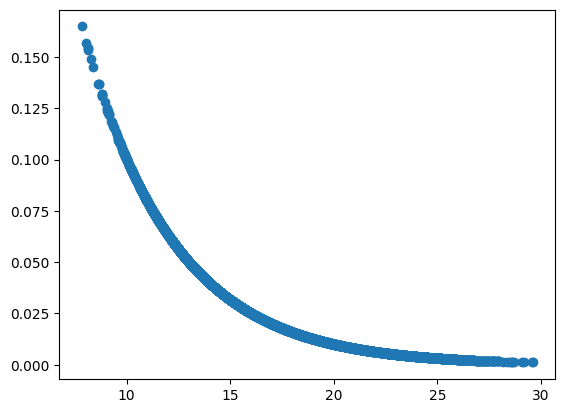

In [79]:
plt.scatter(metrf.keys(),metrf.values())

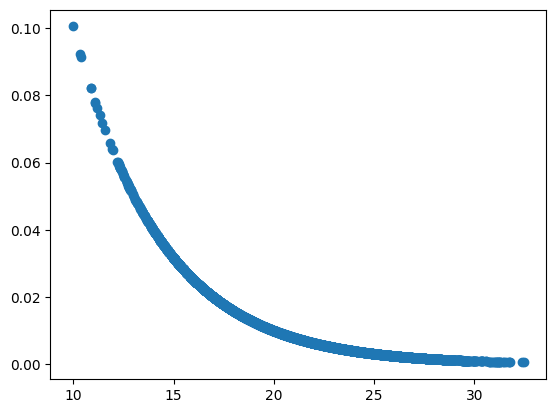

In [70]:
plt.scatter(metr.keys(),metr.values())

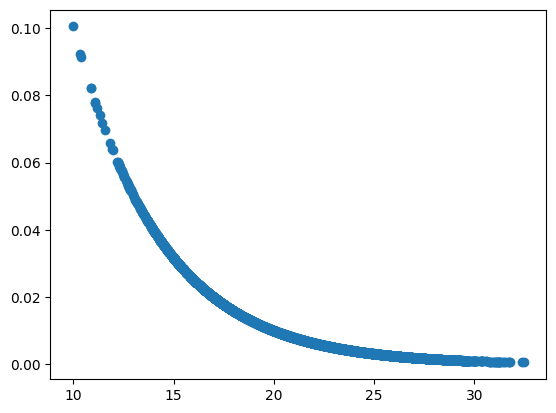

In [71]:
plt.scatter(sorted(metr.keys()),[metr[i] for i in sorted(metr.keys())])

Text(0, 0.5, 'MSE')

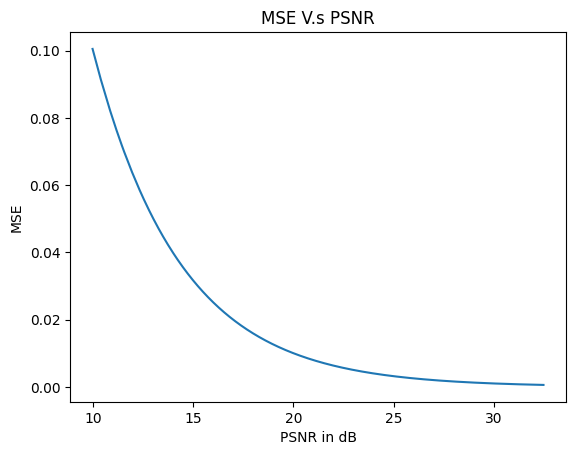

In [97]:
plt.plot(sorted(metr.keys()),[metr[i] for i in sorted(metr.keys())])
plt.title('MSE V.s PSNR')
plt.xlabel('PSNR in dB')
plt.ylabel('MSE')

In [99]:
a=np.arange(0,30,2)
len(a)

15